# Data Science Bowl: Detecting Lung Cancer From Chest Scans

In [1]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import warnings

from skimage import measure, morphology
from skimage.transform import resize

import ipyvolume.pylab as p3

%matplotlib inline
warnings.filterwarnings("ignore")

### Constants

In [2]:
INPUT_FOLDER = 'stage1/'
MASK_FOLDER = 'stage1_masks/'
PREPD_FOLDER = 'prepd_stage1/'
IM_SIZE = 128
patients = os.listdir(INPUT_FOLDER)
patients.sort()

## Loading the files

In [3]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [5]:
def get_batches(patients):
    for ix, patient in enumerate(patients):
        scan = load_scan(INPUT_FOLDER + patient)
        slices = get_pixels_hu(scan)
        if ix % 10 == 0:
            print("Processed patient {0} of {1}".format(ix, len(patients)))
        yield scan, slices, patient

## Utils

In [6]:
def save_array(path, arr):
    np.save(path, arr)
    

def load_array(path):
    return np.load(path)

## Resampling

In [7]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    thickness = [scan[0].SliceThickness]

    if not thickness[0]:
        thickness = [1.0]  # because weird error
        
    spacing = np.array(thickness + scan[0].PixelSpacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image

## Normalization

In [8]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

## Zero Centering

In [9]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

## Lung segmentation

In [10]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
        
    for i, axial_slice in enumerate(binary_image):  # one last dilation
        binary_image[i] = morphology.dilation(axial_slice, np.ones([10,10]))
 
    return binary_image


def save_masks(scan, patient):
    masks = segment_lung_mask(scan, True)
    np.save(MASK_FOLDER + "{}.npy".format(patient), masks)
    return masks

In [11]:
def apply_masks(imgs, masks):
    out_images = []
    for i in range(len(imgs)):
        mask = masks[i]
        img = imgs[i]
        img= mask*img  # apply lung mask
        img = resize(img, [IM_SIZE, IM_SIZE]) # resize
        out_images.append(img)
    return np.array(out_images)


def save_preprocessed(patient, scan, masks):
    normalized = normalize(scan)
    centered = zero_center(normalized)
    masked = apply_masks(centered, masks)
    save_array(PREPD_FOLDER + "{}.npy".format(patient), masked)

## Run Pipeline

In [13]:
gen = get_batches(patients)

for scan, slices, patient in gen:
    try:
        resampled = resample(slices, scan)
        masks = save_masks(resampled, patient)
        save_preprocessed(patient, resampled, masks)
    except Exception as e:
        print(patient, e)

Processed patient 0 of 458
Processed patient 10 of 458
Processed patient 20 of 458
Processed patient 30 of 458
Processed patient 40 of 458
Processed patient 50 of 458
Processed patient 60 of 458
Processed patient 70 of 458
Processed patient 80 of 458
Processed patient 90 of 458
Processed patient 100 of 458
Processed patient 110 of 458
Processed patient 120 of 458
Processed patient 130 of 458
Processed patient 140 of 458
Processed patient 150 of 458
Processed patient 160 of 458
Processed patient 170 of 458
Processed patient 180 of 458
Processed patient 190 of 458
Processed patient 200 of 458
Processed patient 210 of 458
Processed patient 220 of 458
Processed patient 230 of 458
Processed patient 240 of 458
Processed patient 250 of 458
Processed patient 260 of 458
Processed patient 270 of 458
Processed patient 280 of 458
Processed patient 290 of 458
Processed patient 300 of 458
Processed patient 310 of 458
Processed patient 320 of 458
Processed patient 330 of 458
Processed patient 340 of 

##  Pipeline Visualization

Processed patient 0 of 458


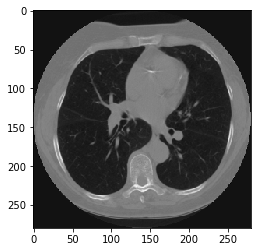

In [15]:
demo_gen = get_batches(patients)  # reset generator
im_index = 100                    # choose a random slice from somewhere near the middle of the scan

scan, slices, patient = next(demo_gen)
resampled = resample(slices, scan)

plt.imshow(resampled[im_index], cmap=plt.cm.gray)

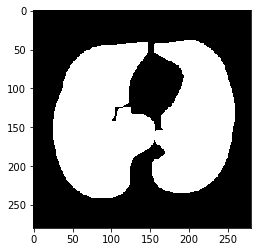

In [16]:
mask = load_array(MASK_FOLDER + '{}.npy'.format(patient))

plt.imshow(mask[im_index], cmap=plt.cm.gray)

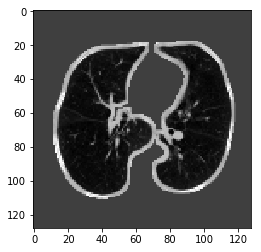

In [17]:
final = load_array(PREPD_FOLDER + '{}.npy'.format(patient))

plt.imshow(final[im_index], cmap=plt.cm.gray)

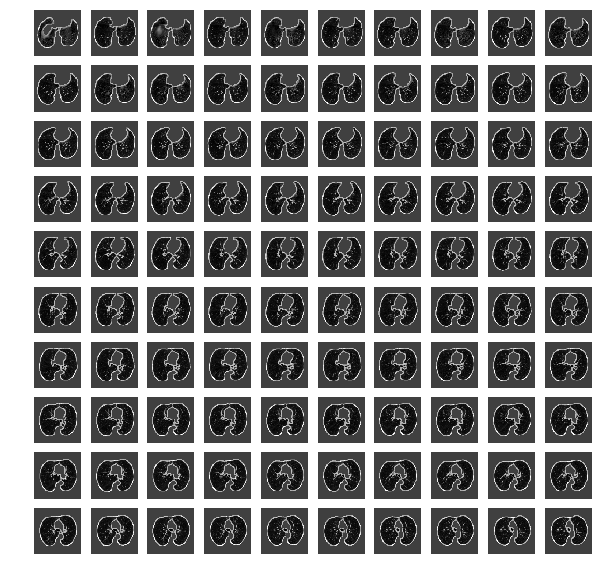

In [18]:
f, plots = plt.subplots(10, 10, sharex='all', sharey='all', figsize=(10, 10))

for i in range(100):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(final[i+50], cmap=plt.cm.gray)

In [19]:
print("Max pixel value:", np.max(final))
print("Min pixel value:", np.min(final))
print("Mean pixel value:", np.mean(final))
print("Pixel Std. Dev:", np.std(final))

Max pixel value: 0.75
Min pixel value: -0.25
Mean pixel value: -0.000614718667098
Pixel Std. Dev: 0.145203490805


In [20]:
s = p3.volshow(final)

p3.xyzlim(-1, 1)
p3.animate_glyphs(s) # shows controls for animation controls
p3.show()

AttributeError: 'VolumeRendererThree' object has no attribute 'x'